In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, io
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [2]:
class WildfireDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = io.read_image(img_path).float() / 255 
        if self.transform:
            image = self.transform(image)
        labels = self.img_labels.iloc[idx, 1:].to_numpy()
        label = labels.argmax()
        return image, label


In [3]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = WildfireDataset('fireclassify.v1i.multiclass/train/_classes.csv', 'fireclassify.v1i.multiclass/train', transform=transform)
valid_dataset = WildfireDataset('fireclassify.v1i.multiclass/valid/_classes.csv', 'fireclassify.v1i.multiclass/valid', transform=transform)
test_dataset = WildfireDataset('fireclassify.v1i.multiclass/test/_classes.csv', 'fireclassify.v1i.multiclass/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
results = {}
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [5]:
from torchvision import models

efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet = efficientnet.to(device)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
class CustomEfficientNet(nn.Module):
    def __init__(self, original_model, num_classes=3):
        super(CustomEfficientNet, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
        self._out_features = self._get_conv_output((3, 224, 224))

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._out_features, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape)).to(device)
        
        output_feat = self.features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:

model = CustomEfficientNet(efficientnet, num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [8]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

model_name = "CustomEfficientNet"
results[model_name] = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': []}



for epoch in range(1, 10):
    train_loss, valid_loss = 0.0, 0.0
    correct_train, total_train, correct_valid, total_valid = 0, 0, 0, 0
    
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(output.data, 1)
            total_valid += target.size(0)
            correct_valid += (predicted == target).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    train_accuracy = correct_train / total_train
    valid_accuracy = correct_valid / total_valid
    
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tTraining Accuracy: {train_accuracy:.2f} \tValidation Accuracy: {valid_accuracy:.2f}')
    
    results[model_name]['train_loss'].append(train_loss)
    results[model_name]['valid_loss'].append(valid_loss)
    results[model_name]['train_accuracy'].append(train_accuracy)
    results[model_name]['valid_accuracy'].append(valid_accuracy)


Epoch: 1 	Training Loss: 0.325983 	Validation Loss: 0.121065 	Training Accuracy: 0.88 	Validation Accuracy: 0.97
Epoch: 2 	Training Loss: 0.039385 	Validation Loss: 0.006938 	Training Accuracy: 0.99 	Validation Accuracy: 1.00
Epoch: 3 	Training Loss: 0.031335 	Validation Loss: 0.023602 	Training Accuracy: 0.99 	Validation Accuracy: 0.99
Epoch: 4 	Training Loss: 0.009707 	Validation Loss: 0.031704 	Training Accuracy: 1.00 	Validation Accuracy: 0.99
Epoch: 5 	Training Loss: 0.047277 	Validation Loss: 0.097528 	Training Accuracy: 0.98 	Validation Accuracy: 0.95
Epoch: 6 	Training Loss: 0.162343 	Validation Loss: 0.069748 	Training Accuracy: 0.97 	Validation Accuracy: 0.97
Epoch: 7 	Training Loss: 0.125049 	Validation Loss: 0.001067 	Training Accuracy: 0.97 	Validation Accuracy: 1.00
Epoch: 8 	Training Loss: 0.035874 	Validation Loss: 0.003563 	Training Accuracy: 0.99 	Validation Accuracy: 1.00
Epoch: 9 	Training Loss: 0.025281 	Validation Loss: 0.000664 	Training Accuracy: 0.99 	Validatio

In [9]:
def evaluate_model(model, loader):
    model.eval()
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
            total += labels.size(0)

    accuracy = running_corrects.float() / total
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy


print("Evaluating on Validation Set:")
evaluate_model(model, valid_loader)

print("Evaluating on Test Set:")
evaluate_model(model, test_loader)


print("Evaluating on Test Set:")
evaluate_model(model, test_loader)


Evaluating on Validation Set:
Accuracy: 1.0000
Evaluating on Test Set:
Accuracy: 1.0000
Evaluating on Test Set:
Accuracy: 1.0000


In [19]:

class CNNNet1(nn.Module):
    def __init__(self, num_classes):
        super(CNNNet1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)

        self.fc2 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [20]:
model = CNNNet1(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [21]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
model_name = "CNNNet1"
results[model_name] = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': []}



for epoch in range(1, 10):
    train_loss, valid_loss = 0.0, 0.0
    correct_train, total_train, correct_valid, total_valid = 0, 0, 0, 0
    
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(output.data, 1)
            total_valid += target.size(0)
            correct_valid += (predicted == target).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    train_accuracy = correct_train / total_train
    valid_accuracy = correct_valid / total_valid
    
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tTraining Accuracy: {train_accuracy:.2f} \tValidation Accuracy: {valid_accuracy:.2f}')
    
    results[model_name]['train_loss'].append(train_loss)
    results[model_name]['valid_loss'].append(valid_loss)
    results[model_name]['train_accuracy'].append(train_accuracy)
    results[model_name]['valid_accuracy'].append(valid_accuracy)


print("Evaluating on Validation Set:")
evaluate_model(model, valid_loader)

print("Evaluating on Test Set:")
evaluate_model(model, test_loader)


print("Evaluating on Test Set:")
evaluate_model(model, test_loader)


Epoch: 1 	Training Loss: 34.147934 	Validation Loss: 4.292191 	Training Accuracy: 0.65 	Validation Accuracy: 0.08
Epoch: 2 	Training Loss: 1.252234 	Validation Loss: 0.679023 	Training Accuracy: 0.71 	Validation Accuracy: 0.76
Epoch: 3 	Training Loss: 0.671514 	Validation Loss: 0.580718 	Training Accuracy: 0.76 	Validation Accuracy: 0.76
Epoch: 4 	Training Loss: 0.551405 	Validation Loss: 0.493135 	Training Accuracy: 0.78 	Validation Accuracy: 0.76
Epoch: 5 	Training Loss: 0.472377 	Validation Loss: 0.384505 	Training Accuracy: 0.78 	Validation Accuracy: 0.76
Epoch: 6 	Training Loss: 0.361111 	Validation Loss: 0.319088 	Training Accuracy: 0.79 	Validation Accuracy: 0.79
Epoch: 7 	Training Loss: 0.286099 	Validation Loss: 0.354392 	Training Accuracy: 0.81 	Validation Accuracy: 0.76
Epoch: 8 	Training Loss: 0.260634 	Validation Loss: 0.275637 	Training Accuracy: 0.86 	Validation Accuracy: 0.86
Epoch: 9 	Training Loss: 0.211377 	Validation Loss: 0.279512 	Training Accuracy: 0.91 	Validati

In [ ]:
print(results)

In [40]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.avgpool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 7 * 7, 4096),  
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x) 
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x


In [41]:
model = AlexNet(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [42]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
model_name = "AlexNet"
results[model_name] = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': []}



for epoch in range(1, 10):
    train_loss, valid_loss = 0.0, 0.0
    correct_train, total_train, correct_valid, total_valid = 0, 0, 0, 0
    
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(output.data, 1)
            total_valid += target.size(0)
            correct_valid += (predicted == target).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    train_accuracy = correct_train / total_train
    valid_accuracy = correct_valid / total_valid
    
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tTraining Accuracy: {train_accuracy:.2f} \tValidation Accuracy: {valid_accuracy:.2f}')
    
    results[model_name]['train_loss'].append(train_loss)
    results[model_name]['valid_loss'].append(valid_loss)
    results[model_name]['train_accuracy'].append(train_accuracy)
    results[model_name]['valid_accuracy'].append(valid_accuracy)


print("Evaluating on Validation Set:")
evaluate_model(model, valid_loader)

print("Evaluating on Test Set:")
evaluate_model(model, test_loader)


print("Evaluating on Test Set:")
evaluate_model(model, test_loader)


Epoch: 1 	Training Loss: 99452.518958 	Validation Loss: 0.775001 	Training Accuracy: 0.58 	Validation Accuracy: 0.76
Epoch: 2 	Training Loss: 10.294224 	Validation Loss: 1.661049 	Training Accuracy: 0.63 	Validation Accuracy: 0.04
Epoch: 3 	Training Loss: 1.615887 	Validation Loss: 2.264501 	Training Accuracy: 0.68 	Validation Accuracy: 0.76
Epoch: 4 	Training Loss: 10.539943 	Validation Loss: 4.344022 	Training Accuracy: 0.71 	Validation Accuracy: 0.76
Epoch: 5 	Training Loss: 22.052451 	Validation Loss: 24.978910 	Training Accuracy: 0.70 	Validation Accuracy: 0.16
Epoch: 6 	Training Loss: 45.362769 	Validation Loss: 7.436359 	Training Accuracy: 0.58 	Validation Accuracy: 0.76
Epoch: 7 	Training Loss: 9.635281 	Validation Loss: 1.080979 	Training Accuracy: 0.69 	Validation Accuracy: 0.77
Epoch: 8 	Training Loss: 4.259195 	Validation Loss: 1.041960 	Training Accuracy: 0.71 	Validation Accuracy: 0.76
Epoch: 9 	Training Loss: 2.666858 	Validation Loss: 0.566764 	Training Accuracy: 0.73 	

In [49]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.input_fc = nn.Linear(input_dim, 512) 
        self.hidden_fc = nn.Linear(512, 256)  
        self.output_fc = nn.Linear(256, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred


In [50]:
model = MLP(input_dim=150528, output_dim=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [51]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
model_name = "MLP"
results[model_name] = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': []}



for epoch in range(1, 10):
    train_loss, valid_loss = 0.0, 0.0
    correct_train, total_train, correct_valid, total_valid = 0, 0, 0, 0
    
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(output.data, 1)
            total_valid += target.size(0)
            correct_valid += (predicted == target).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    train_accuracy = correct_train / total_train
    valid_accuracy = correct_valid / total_valid
    
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tTraining Accuracy: {train_accuracy:.2f} \tValidation Accuracy: {valid_accuracy:.2f}')
    
    results[model_name]['train_loss'].append(train_loss)
    results[model_name]['valid_loss'].append(valid_loss)
    results[model_name]['train_accuracy'].append(train_accuracy)
    results[model_name]['valid_accuracy'].append(valid_accuracy)


print("Evaluating on Validation Set:")
evaluate_model(model, valid_loader)

print("Evaluating on Test Set:")
evaluate_model(model, test_loader)

print("Evaluating on Test Set:")
evaluate_model(model, test_loader)


Epoch: 1 	Training Loss: 98.523670 	Validation Loss: 11.337652 	Training Accuracy: 0.72 	Validation Accuracy: 0.86
Epoch: 2 	Training Loss: 9.979245 	Validation Loss: 5.637781 	Training Accuracy: 0.92 	Validation Accuracy: 0.95
Epoch: 3 	Training Loss: 1.560319 	Validation Loss: 2.789348 	Training Accuracy: 0.94 	Validation Accuracy: 0.96
Epoch: 4 	Training Loss: 0.698868 	Validation Loss: 3.371616 	Training Accuracy: 0.98 	Validation Accuracy: 0.95
Epoch: 5 	Training Loss: 0.501725 	Validation Loss: 2.011496 	Training Accuracy: 0.98 	Validation Accuracy: 0.96
Epoch: 6 	Training Loss: 0.015723 	Validation Loss: 1.470016 	Training Accuracy: 0.99 	Validation Accuracy: 0.97
Epoch: 7 	Training Loss: 0.104078 	Validation Loss: 3.529469 	Training Accuracy: 0.99 	Validation Accuracy: 0.98
Epoch: 8 	Training Loss: 0.010455 	Validation Loss: 5.538982 	Training Accuracy: 1.00 	Validation Accuracy: 0.97
Epoch: 9 	Training Loss: 0.127484 	Validation Loss: 5.464622 	Training Accuracy: 0.99 	Validat

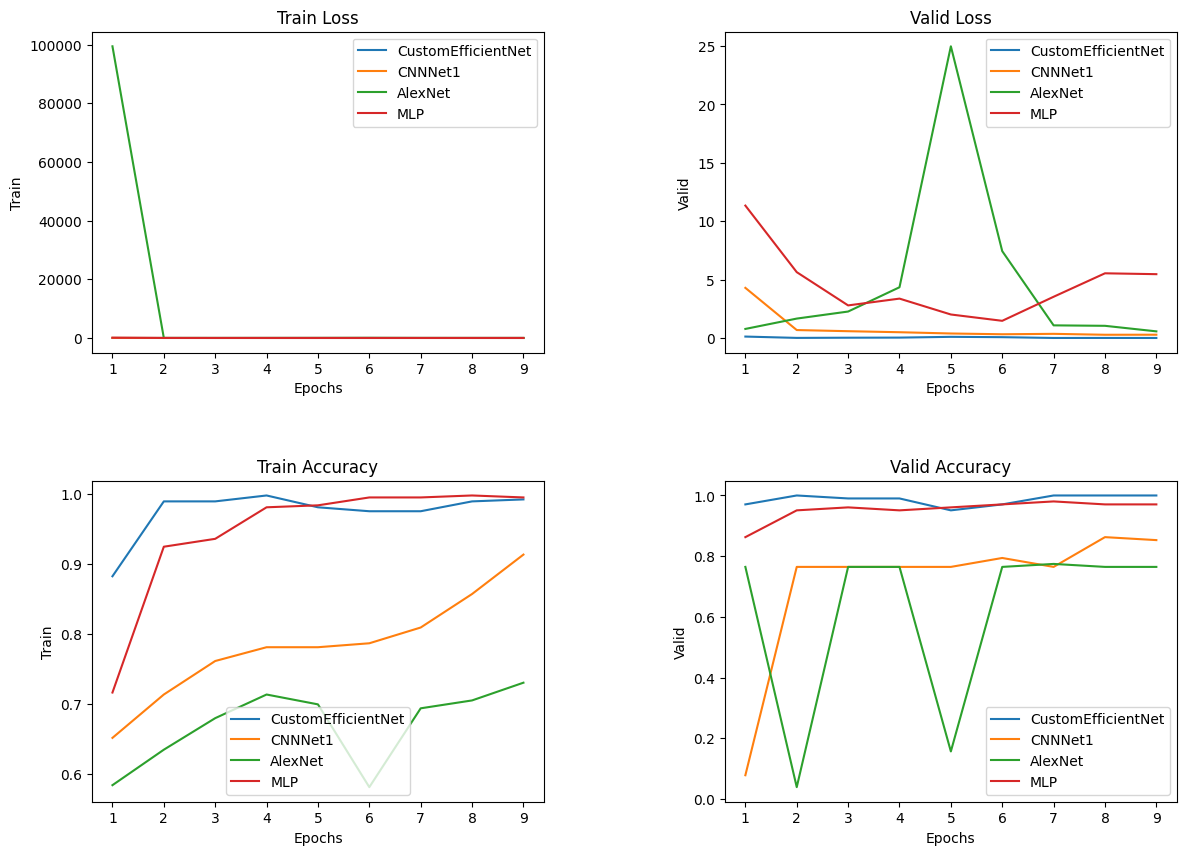

In [54]:
import matplotlib.pyplot as plt

model_names = ['CustomEfficientNet', 'CNNNet1', 'AlexNet', 'MLP']
metrics = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    for model_name in model_names:
        epochs = list(range(1, len(results[model_name][metric])+1))
        ax.plot(epochs, results[model_name][metric], label=model_name)
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric.split('_')[0].title())
    ax.legend()

plt.show()
